In [1]:
#Tracking of Cursor movement with Eyeball using Hidden Markov Model

In [2]:
!pip install scikit-image

In [3]:
!pip install --upgrade scikit-image

In [4]:
!pip install scikit-image==0.13.1
from skimage.util import montage
from skimage.util import montage as montage2d

  Using cached scikit-image-0.13.1.tar.gz (26.1 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for scikit-image
Failed to build scikit-image
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.22.0
    Uninstalling scikit-image-0.22.0:
      Successfully uninstalled scikit-image-0.22.0
  Running setup.py install for scikit-image: started
  Running setup.py install for scikit-image: finished with status 'error'
  Rolling back uninstall of scikit-image
  Moving to c:\users\tanusha\anaconda3\lib\site-packages\scikit_image-0.22.0.dist-info\
   from C:\Users\Tanusha\anaconda3\Lib\site-packages\~cikit_image-0.22.0.dist-info
  Moving to c:\users\tanusha\anaconda3\lib\site-packages\skimage\
   from C:\Users\Tanusha\anaconda3\Lib\site-packages\~kimage


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [503 lines of output]
  C:\Users\Tanusha\AppData\Local\Temp\pip-install-gtxvctxd\scikit-image_9b2d27111d4342a5af14a0e78219f503\setup.py:78: DeprecationWarning:
  
    `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
    of the deprecation of `distutils` itself. It will be removed for
    Python >= 3.12. For older Python versions it will remain present.
    It is recommended to use `setuptools < 60.0` for those Python versions.
    For more details, see:
      https://numpy.org/devdocs/reference/distutils_status_migration.html
  
  
    from numpy.distutils.core import setup
  Partial import of skimage during the build process.
  Cython >= 0.23 not found; falling back to pre-built geometry.c
  Cython >= 0.23 not found; falling back to pre-built transform.c
  Cython >= 0.23 not found; falling back to pre-built interpolation.c
  Cython >= 0.23 not found; fall

C:\Users\Tanusha\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [5]:
%matplotlib inline
import os
from glob import glob
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from skimage.io import imread
from scipy.io import loadmat # for loading mat files
from tqdm import tqdm_notebook
root_mpi_dir = os.path.join('MPIIGaze')
data_dir = os.path.join(root_mpi_dir, 'Data')
annot_dir = os.path.join(root_mpi_dir, 'Annotation Subset') # annotations the important part of the data
img_dir = os.path.join(data_dir, 'original')

In [6]:
#reading annotations

In [7]:
def read_annot(in_path):
    r_dir = os.path.splitext(os.path.basename(in_path))[0]
    c_df = pd.read_table(in_path, header = None, sep = ' ')
    c_df.columns = ['path' if i<0 else ('x{}'.format(i//2) if i % 2 == 0 else 'y{}'.format(i//2)) for i, x in enumerate(c_df.columns, -1)]
    c_df['path'] = c_df['path'].map(lambda x: os.path.join(img_dir, r_dir, x))
    c_df['group'] = r_dir
    c_df['exists'] = c_df['path'].map(os.path.exists)
    return c_df

In [8]:
all_annot_df = pd.concat([read_annot(c_path) for c_path in glob(os.path.join(annot_dir, '*'))], ignore_index=True)
print(all_annot_df.shape[0], 'annotations')
print('Missing %2.2f%%' % (100-100*all_annot_df['exists'].mean()))
all_annot_df = all_annot_df[all_annot_df['exists']].drop('exists', 1)
all_annot_df.sample(3)

10654 annotations
Missing 80.23%


C:\Users\Tanusha\AppData\Local\Temp\ipykernel_21512\3499930305.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  all_annot_df = all_annot_df[all_annot_df['exists']].drop('exists', 1)


,path,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,group
8614,MPIIGaze\Data\original\p11\day09/0066.jpg,591,396,645,397,708,391,759,391,637,534,718,534,615,393,728,388,p11
4736,MPIIGaze\Data\original\p05\day33/0095.jpg,520,337,570,340,636,343,690,345,552,464,635,470,543,337,660,342,p05
8707,MPIIGaze\Data\original\p11\day15/0029.jpg,546,340,601,340,656,335,706,331,595,464,680,458,574,336,679,328,p11


In [9]:
# Print the list of annotation files
print("Annotation Files:")
print(glob(os.path.join(annot_dir, '*')))

Annotation Files:
['MPIIGaze\\Annotation Subset\\p00.txt', 'MPIIGaze\\Annotation Subset\\p01.txt', 'MPIIGaze\\Annotation Subset\\p02.txt', 'MPIIGaze\\Annotation Subset\\p03.txt', 'MPIIGaze\\Annotation Subset\\p04.txt', 'MPIIGaze\\Annotation Subset\\p05.txt', 'MPIIGaze\\Annotation Subset\\p06.txt', 'MPIIGaze\\Annotation Subset\\p07.txt', 'MPIIGaze\\Annotation Subset\\p08.txt', 'MPIIGaze\\Annotation Subset\\p09.txt', 'MPIIGaze\\Annotation Subset\\p10.txt', 'MPIIGaze\\Annotation Subset\\p11.txt', 'MPIIGaze\\Annotation Subset\\p12.txt', 'MPIIGaze\\Annotation Subset\\p13.txt', 'MPIIGaze\\Annotation Subset\\p14.txt']


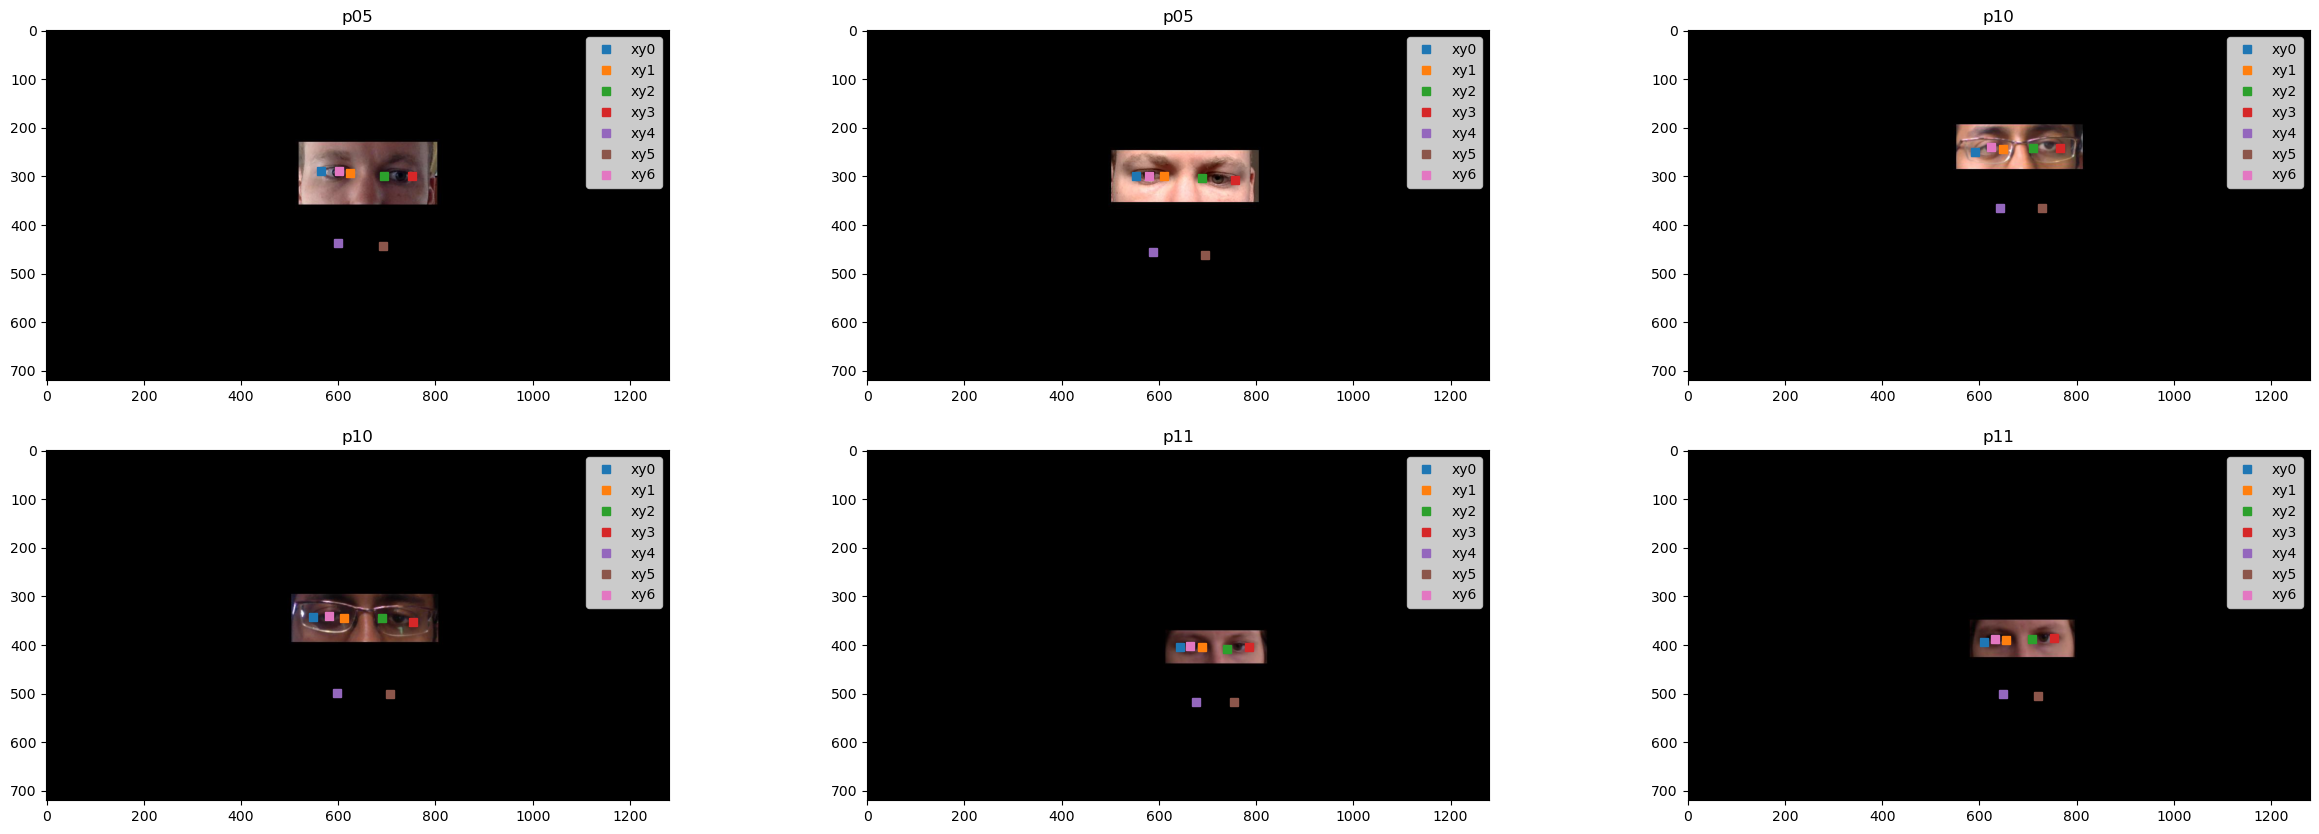

In [10]:
group_view = all_annot_df.groupby('group').apply(lambda x: x.sample(2)).reset_index(drop = True)
fig, m_axs = plt.subplots(2, 3, figsize = (30, 10))
for (_, c_row), c_ax in zip(group_view.iterrows(), m_axs.flatten()):
    c_img = imread(c_row['path'])
    c_ax.imshow(c_img)
    for i in range(7):
        c_ax.plot(c_row['x{}'.format(i)], c_row['y{}'.format(i)], 's', label = 'xy{}'.format(i))
    c_ax.legend()
    c_ax.set_title('{group}'.format(**c_row))

In [11]:
#Making sense of the points

In [12]:
from scipy.ndimage import zoom
def get_eyeball(in_row, eye_height = 30):
    c_img = imread(in_row['path'])
    min_x = int(in_row['x0'])
    max_x = int(in_row['x1'])
    
    mean_x = (min_x+max_x)/2
    wid_x = (max_x-min_x)
    zoom_factor = 55.0/wid_x
    
    mean_y = (in_row['y0']+in_row['y1'])/2
    eye_height = 1/zoom_factor*35
    # normalized pupil position
    pup_v = 2*zoom_factor*(in_row['x6']-mean_x)/wid_x, 2*zoom_factor*(in_row['y6']-mean_y)/eye_height
    
    min_y = int(mean_y-eye_height//2)
    max_y = int(mean_y+eye_height//2)
    out_img = c_img[min_y:max_y, min_x:max_x]
    rs_img = zoom(out_img, (zoom_factor, zoom_factor, 1))
    return rs_img, pup_v

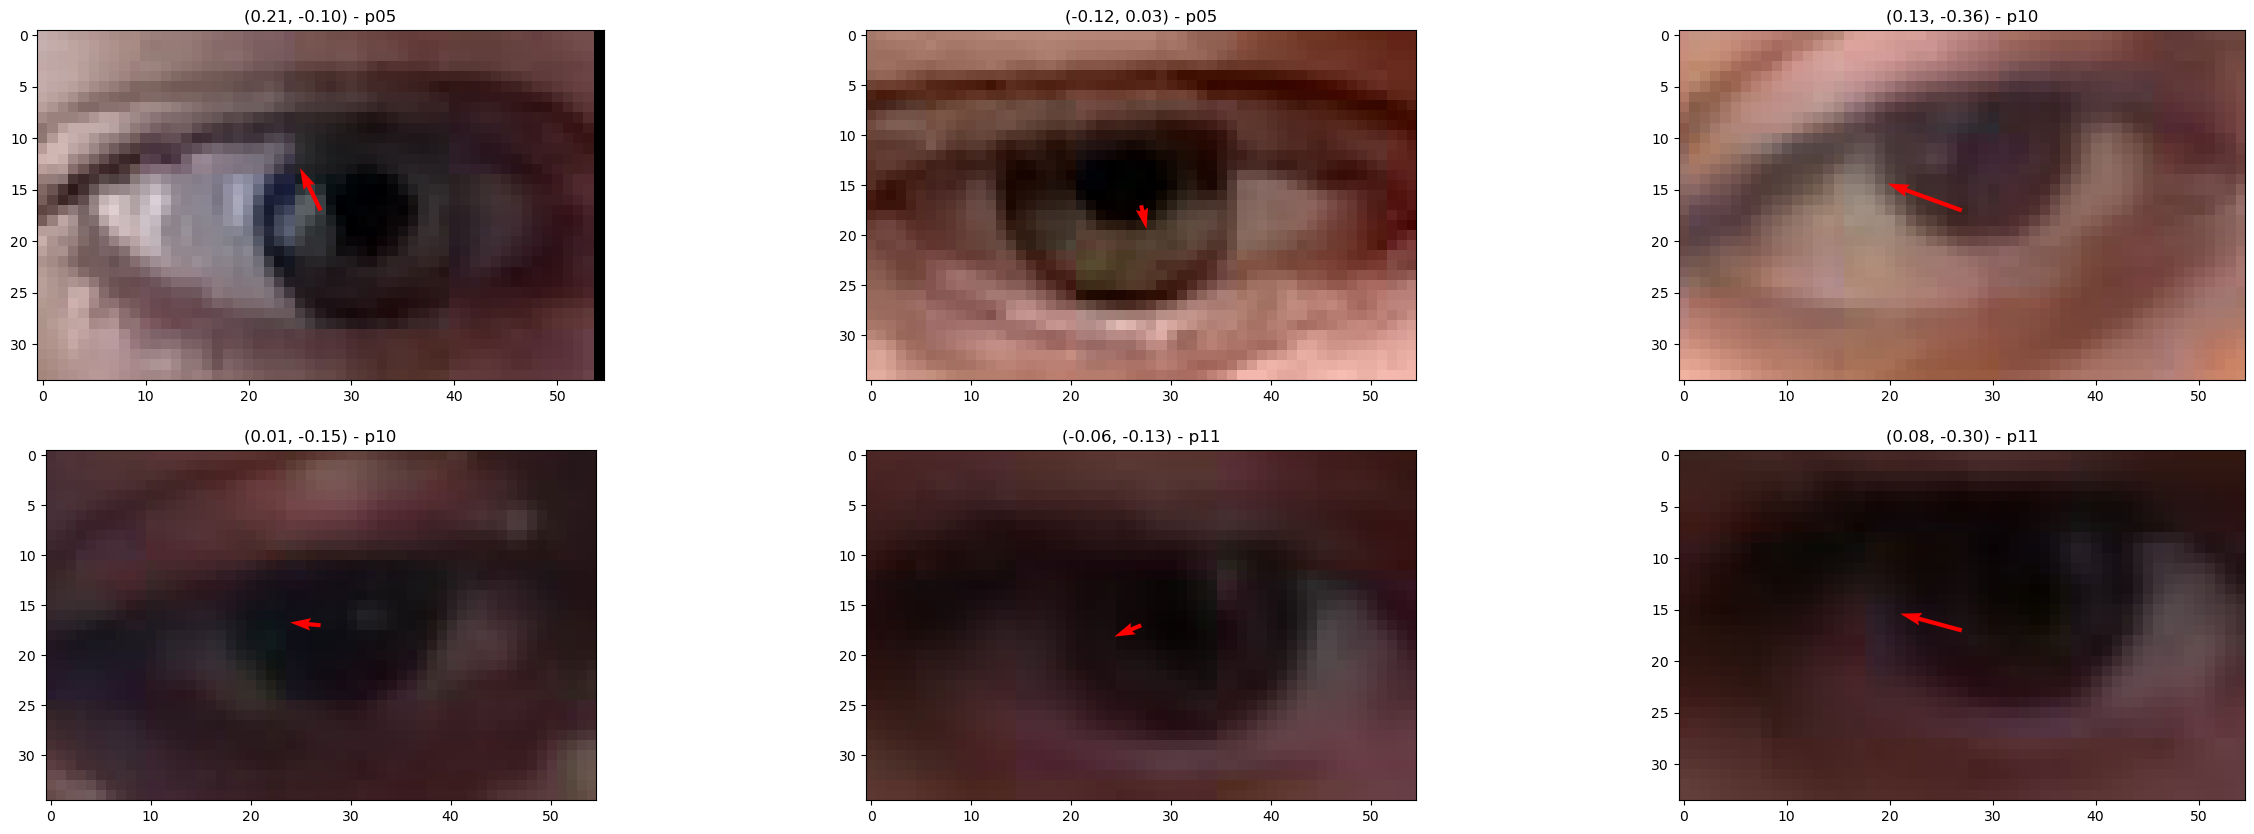

In [13]:
fig, m_axs = plt.subplots(2, 3, figsize = (30, 10))
for (_, c_row), c_ax in zip(group_view.iterrows(), m_axs.flatten()):
    c_img, c_vec = get_eyeball(c_row)
    c_ax.imshow(c_img)
    c_ax.quiver([55//2], [35//2], 20*c_vec[1], 20*c_vec[0], units = 'xy', scale = 1, color = 'red')
    c_ax.set_title('({0:2.2f}, {1:2.2f}) - {group}'.format(*c_vec, **c_row))

In [14]:
all_annot_df['eyeball'] = all_annot_df.apply(get_eyeball, 1)
all_annot_df['pupil_x'] = all_annot_df['eyeball'].map(lambda x: x[1][0])
all_annot_df['pupil_y'] = all_annot_df['eyeball'].map(lambda x: x[1][1])
all_annot_df['eyeball'] = all_annot_df['eyeball'].map(lambda x: x[0])
all_annot_df.sample(3)

,path,x0,y0,x1,y1,x2,y2,x3,y3,x4,...,x5,y5,x6,y6,x7,y7,group,eyeball,pupil_x,pupil_y
8652,MPIIGaze\Data\original\p11\day05/0088.jpg,660,387,729,387,808,384,868,376,712,...,827,549,704,380,839,375,p11,"[[[73, 44, 46], [73, 44, 46], [72, 43, 45], [7...",0.219492,-0.254148
9024,MPIIGaze\Data\original\p11\day03/0084.jpg,593,473,648,473,712,467,766,468,637,...,737,611,620,473,736,462,p11,"[[[124, 82, 86], [124, 82, 84], [125, 83, 84],...",-0.018182,0.000000
8475,MPIIGaze\Data\original\p11\day12/0139.jpg,687,497,739,496,798,498,851,496,729,...,812,633,714,494,828,492,p11,"[[[188, 139, 145], [195, 139, 148], [192, 136,...",0.040680,-0.159816


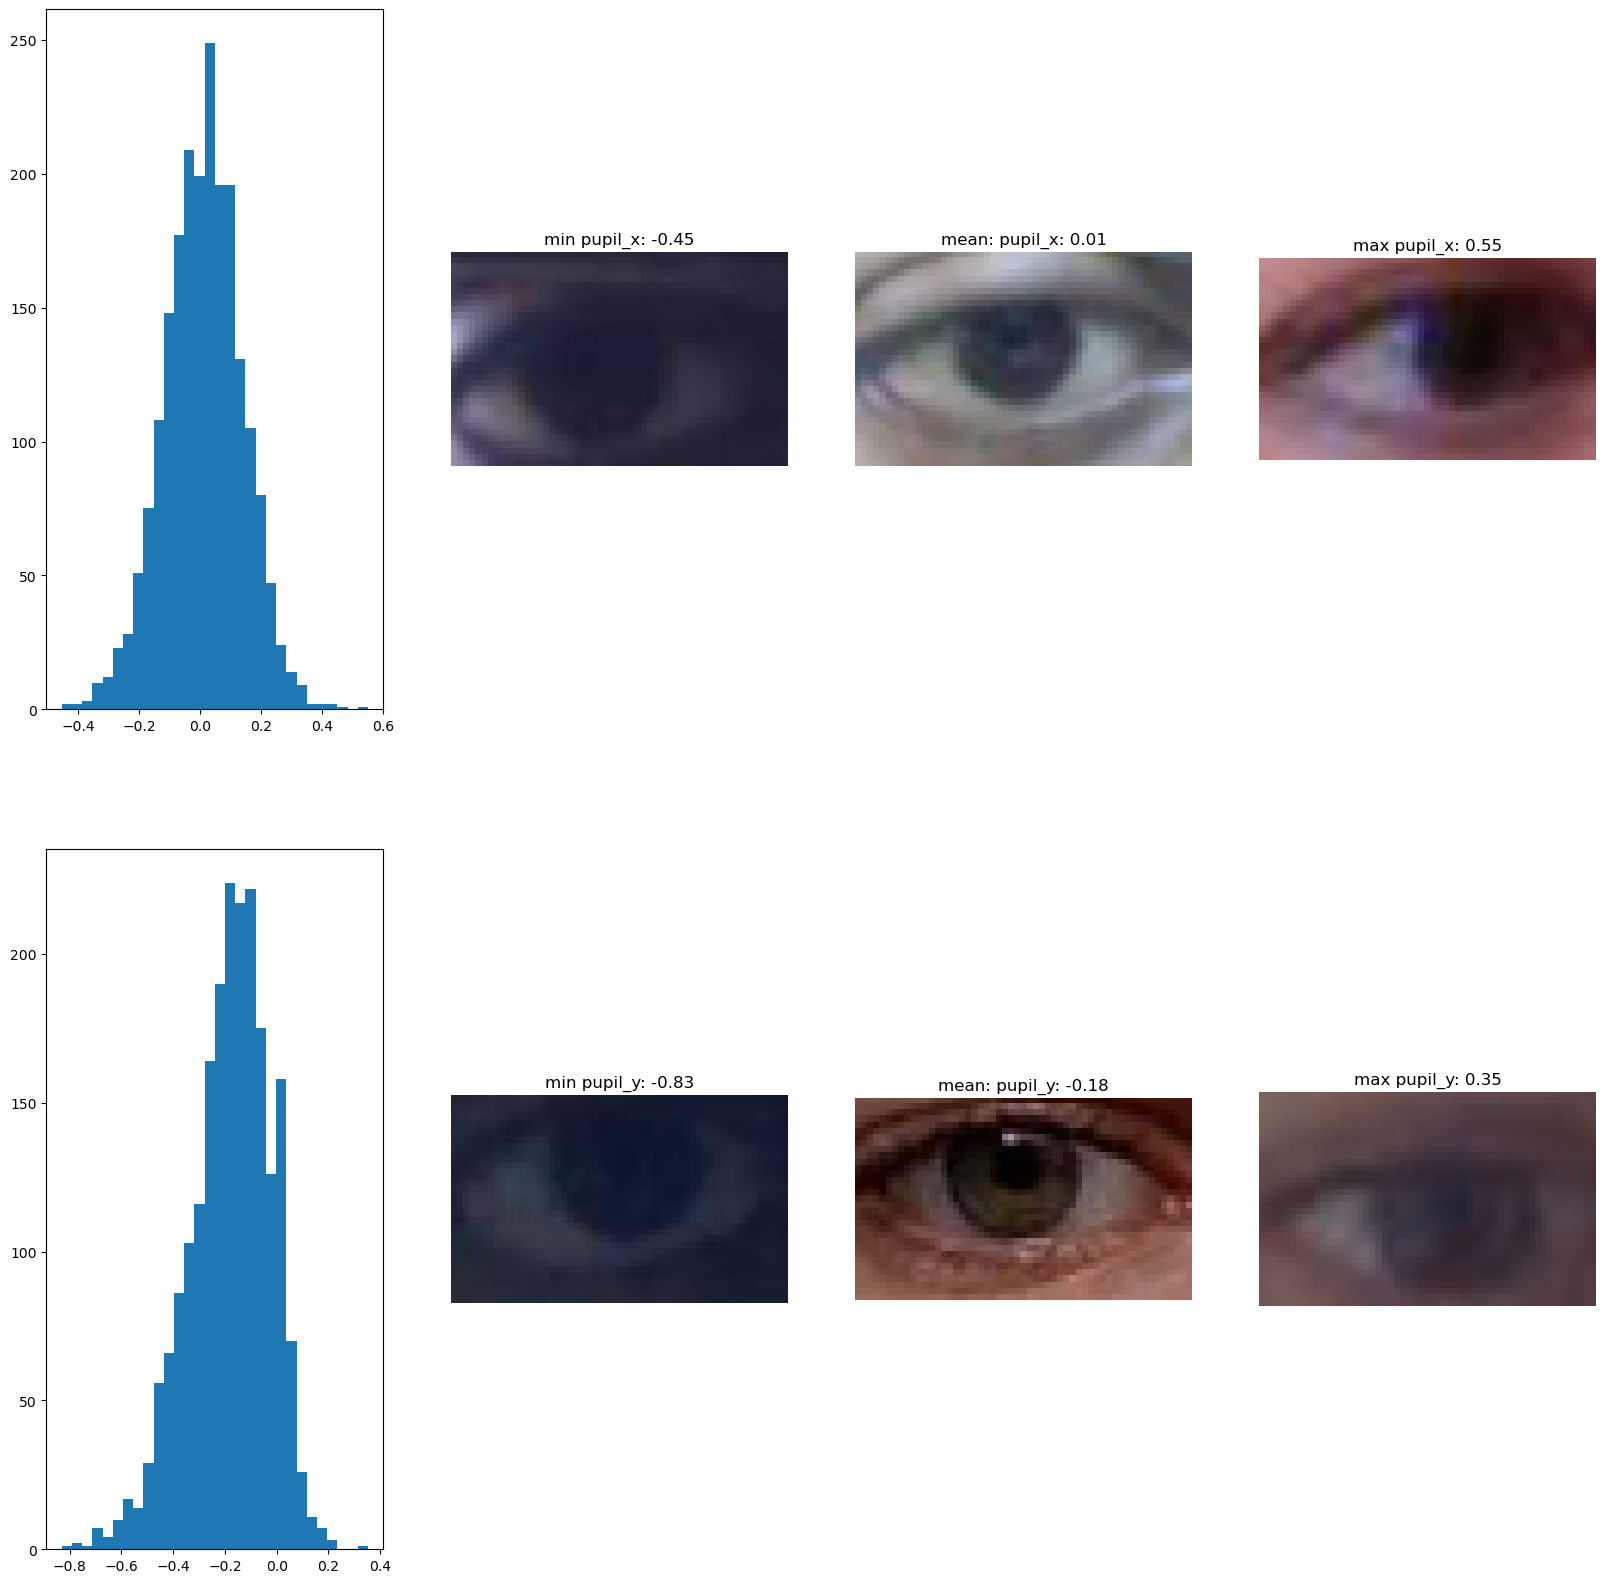

In [15]:
fig, m_axs = plt.subplots(2, 4, figsize = (20, 20))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
from itertools import product
for (ax_dist, ax_min, ax_mean, ax_max), n_ax in zip(m_axs, ['pupil_x', 'pupil_y']):
    # use random sampling to get a better feeling
    c_vec = all_annot_df[n_ax]
    ax_dist.hist(c_vec.values, 30)
    ax_dist.axis('on')
    j = c_vec.idxmin()
    ax_min.imshow(all_annot_df.loc[j]['eyeball'])
    ax_min.set_title('min {}: {:2.2f}'.format(n_ax, all_annot_df.loc[j][n_ax]))
    
    k = c_vec.idxmax()
    ax_max.imshow(all_annot_df.loc[k]['eyeball'])
    ax_max.set_title('max {}: {:2.2f}'.format(n_ax, all_annot_df.loc[k][n_ax]))
    
    p = np.abs(c_vec-np.mean(c_vec)).idxmin()
    ax_mean.imshow(all_annot_df.loc[p]['eyeball'])
    ax_mean.set_title('mean: {}: {:2.2f}'.format(n_ax, all_annot_df.loc[p][n_ax]))

In [16]:
#Read the normalized data

In [17]:
def parse_mat(in_path):
    in_dat = loadmat(in_path, squeeze_me = True, struct_as_record = True)
    vec1_load, img_load,vec2_load = in_dat['data'].tolist()[1].tolist()
    return vec1_load, img_load, vec2_load
def mat_to_df(in_path):
    vec1_load, img_load, vec2_load = parse_mat(in_path)
    c_df = pd.DataFrame(dict(img=[x for x in img_load], 
                             vec1=[x for x in vec1_load],
                            vec2=[x for x in vec2_load]))
    c_df['group'] = os.path.basename(os.path.dirname(in_path))
    c_df['day'] = os.path.splitext(os.path.basename(in_path))[0]
    return c_df
def safe_mat_to_df(in_path):
    try:
        return mat_to_df(in_path)
    except ValueError as e:
        print('ValueError', e, in_path)
        return None
mat_files = glob(os.path.join(root_mpi_dir, '..', 'normalized', '*', '*.mat'))
print(len(mat_files), 'normalized files found')

521 normalized files found


In [18]:
all_norm_df = pd.concat([safe_mat_to_df(in_path) for in_path in tqdm_notebook(mat_files)], ignore_index=True)
all_norm_df.sample(3)

C:\Users\Tanusha\AppData\Local\Temp\ipykernel_21512\2001153779.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  all_norm_df = pd.concat([safe_mat_to_df(in_path) for in_path in tqdm_notebook(mat_files)], ignore_index=True)


  0%|          | 0/521 [00:00<?, ?it/s]

ValueError All arrays must be of the same length MPIIGaze\..\normalized\p01\day39.mat
ValueError All arrays must be of the same length MPIIGaze\..\normalized\p01\day69.mat


,img,vec1,vec2,group,day
79406,"[[41, 40, 40, 40, 38, 36, 33, 32, 28, 21, 12, ...","[-0.027703206588791118, 0.00036261676661905894...","[-0.017499448089626377, -0.019709813826728883,...",p02,day33
206662,"[[157, 157, 157, 135, 112, 96, 96, 112, 96, 96...","[0.09094127241259395, 0.2886223063228307, -0.9...","[-0.005298569897865636, 0.40537204420828277, 0...",p11,day02
44002,"[[44, 26, 19, 17, 19, 14, 15, 9, 3, 2, 3, 18, ...","[0.0319008471361048, 0.06714053266358802, -0.9...","[0.04047829838093554, -0.10151079348489435, 0....",p01,day45


213656 images loaded


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

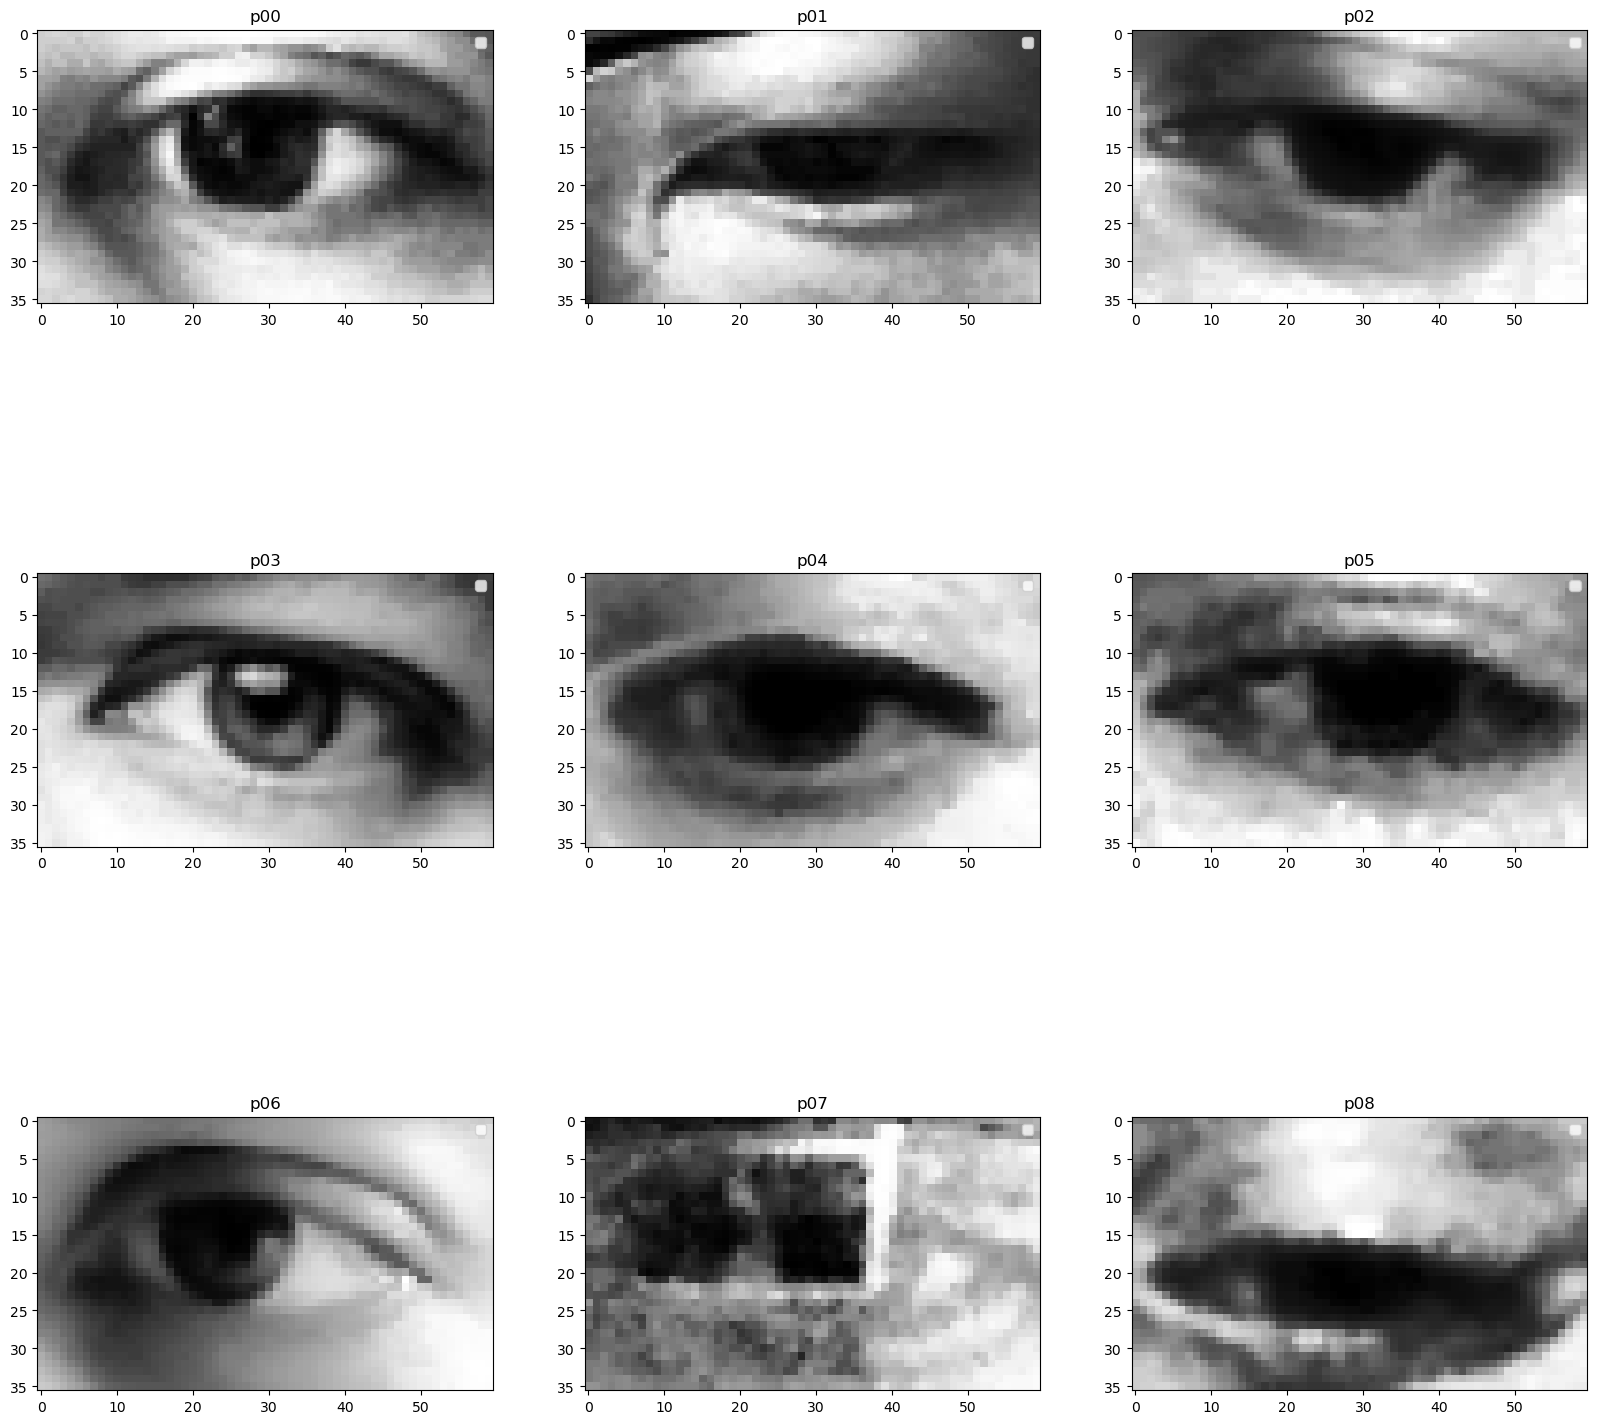

In [19]:
print(all_norm_df.shape[0], 'images loaded')
group_view = all_norm_df.groupby('group').apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, m_axs = plt.subplots(3, 3, figsize = (20, 20))
for (_, c_row), c_ax in zip(group_view.iterrows(), m_axs.flatten()):
    c_ax.imshow(c_row['img'], cmap = 'gray')
    c_ax.legend()
    c_ax.set_title('{group}'.format(**c_row))

In [20]:
for v in ['vec1', 'vec2']:
    for i, x_dim in enumerate('xyz'):
        all_norm_df['{}_{}'.format(v, x_dim)] = all_norm_df[v].map(lambda x: x[i])
all_norm_df.sample(3)

,img,vec1,vec2,group,day,vec1_x,vec1_y,vec1_z,vec2_x,vec2_y,vec2_z
48430,"[[192, 204, 199, 178, 158, 171, 158, 142, 128,...","[-0.20815665442512668, 0.27394261920913515, -0...","[0.07083911686826216, -0.014719438674137305, 0...",p01,day54,-0.208157,0.273943,-0.938950,0.070839,-0.014719,0.000522
179826,"[[29, 35, 32, 29, 35, 43, 49, 44, 46, 59, 65, ...","[0.11934474369456291, 0.22102048478959135, -0....","[-0.6124858492522539, -0.009322376981267953, -...",p07,day42,0.119345,0.221020,-0.967939,-0.612486,-0.009322,-0.002948
76794,"[[61, 43, 43, 49, 61, 61, 65, 53, 49, 43, 32, ...","[-0.20379228373441824, 0.11455510217882015, -0...","[0.055127610737435176, -0.07991415090370585, 0...",p02,day30,-0.203792,0.114555,-0.972289,0.055128,-0.079914,0.002204


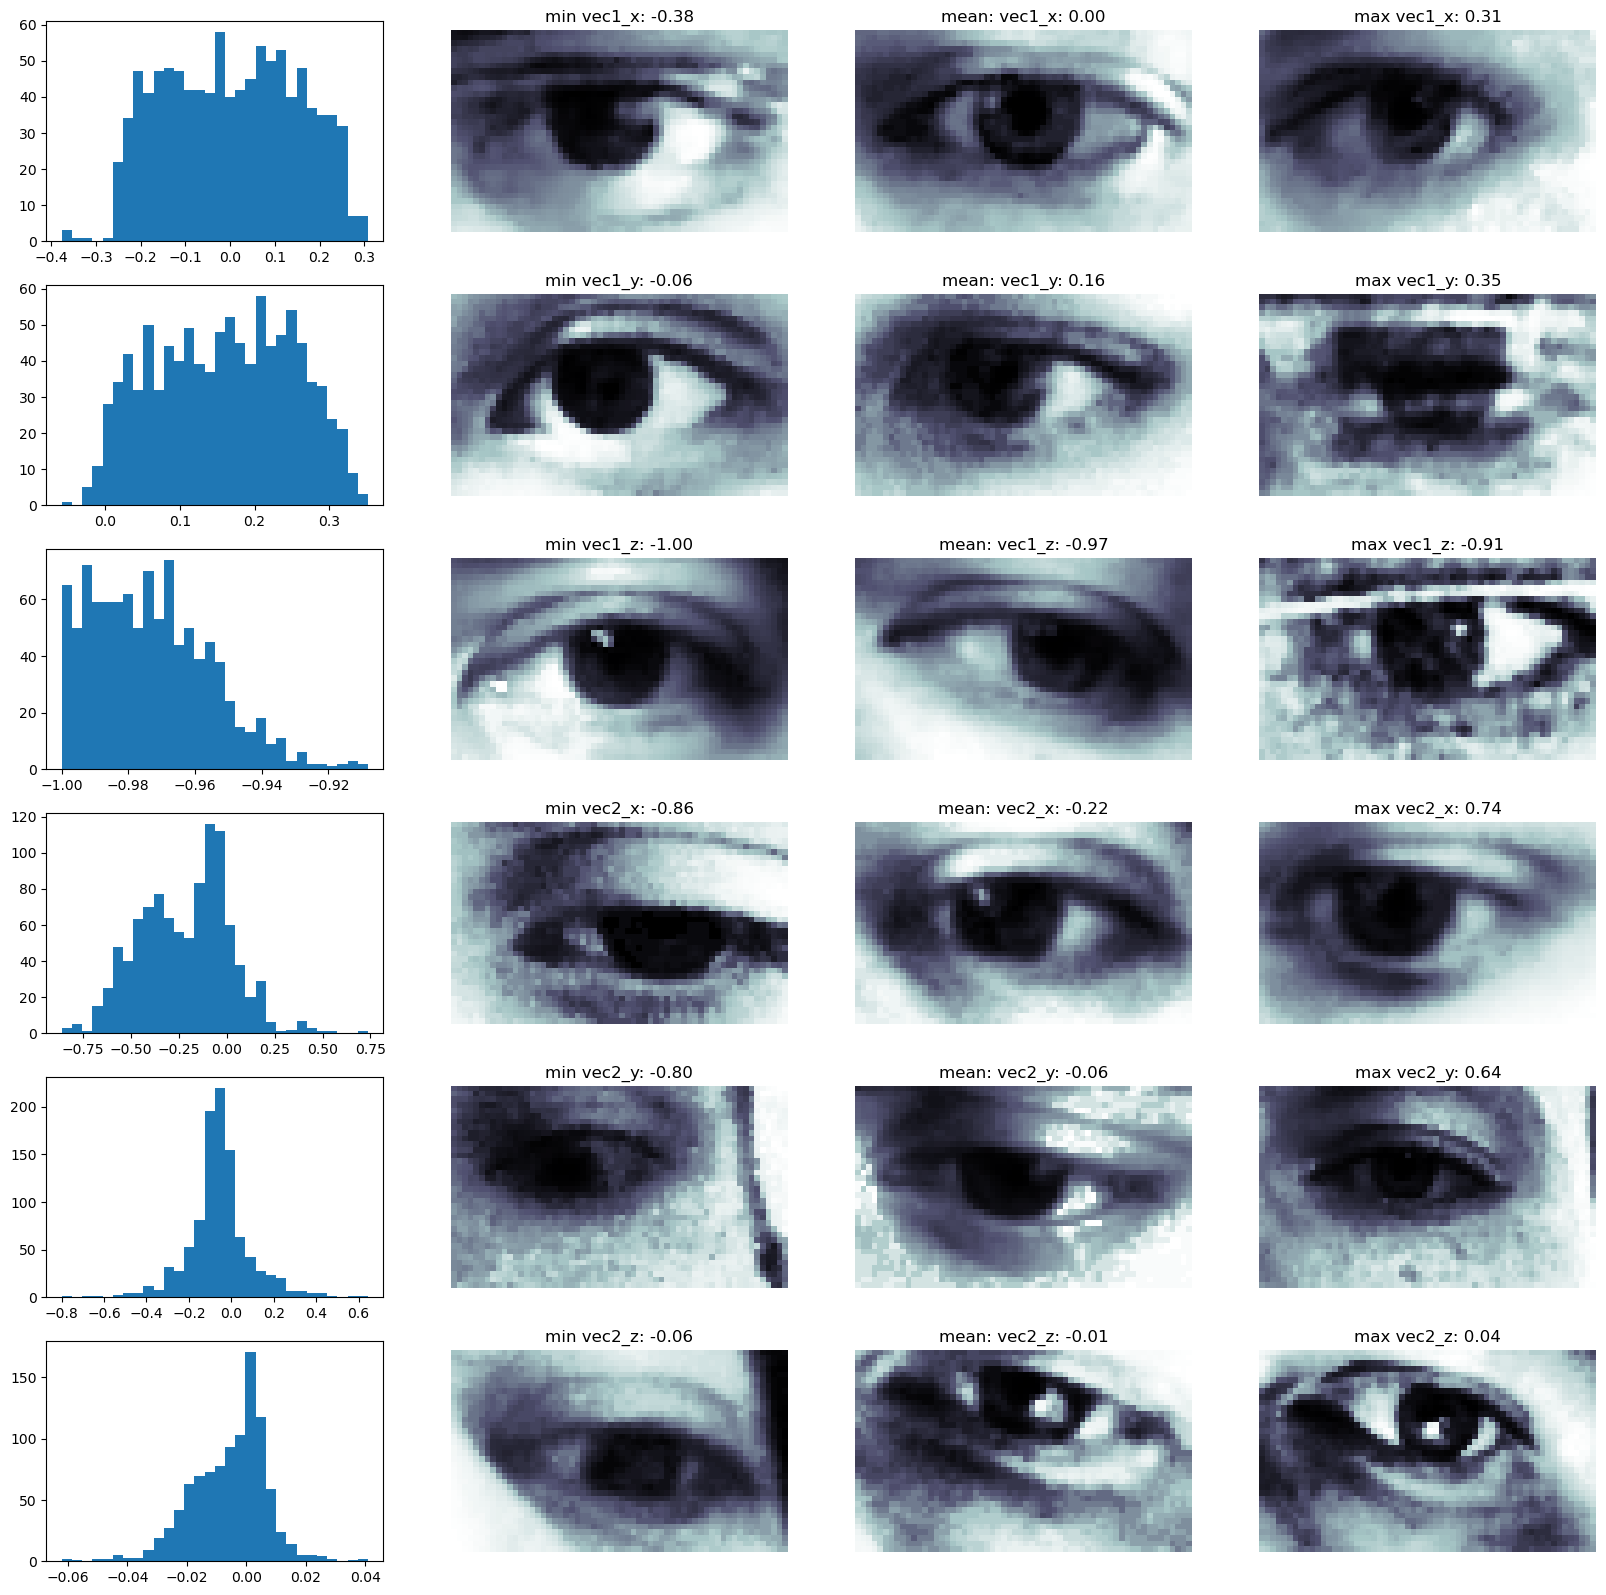

In [21]:
fig, m_axs = plt.subplots(6, 4, figsize = (20, 20))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
from itertools import product
for (ax_dist, ax_min, ax_mean, ax_max), (v, (i, x)) in zip(m_axs, product(['vec1', 'vec2'], enumerate('xyz'))):
    # use random sampling to get a better feeling
    c_vec = all_norm_df.sample(1000)['{}_{}'.format(v, x)]
    ax_dist.hist(c_vec.values, 30)
    ax_dist.axis('on')
    j = c_vec.idxmin()
    ax_min.imshow(all_norm_df.iloc[j]['img'], cmap = 'bone')
    ax_min.set_title('min {}_{}: {:2.2f}'.format(v, x, all_norm_df.iloc[j]['{}_{}'.format(v, x)]))
    
    k = c_vec.idxmax()
    ax_max.imshow(all_norm_df.iloc[k]['img'], cmap = 'bone')
    ax_max.set_title('max {}_{}: {:2.2f}'.format(v, x, all_norm_df.iloc[k]['{}_{}'.format(v, x)]))
    
    p = np.abs(c_vec-np.mean(c_vec)).idxmin()
    ax_mean.imshow(all_norm_df.iloc[p]['img'], cmap = 'bone')
    ax_mean.set_title('mean: {}_{}: {:2.2f}'.format(v, x, all_norm_df.iloc[p]['{}_{}'.format(v, x)]))

In [22]:
img = all_norm_df.iloc[0]['img']

In [23]:
from skimage.feature import blob_doh
from skimage.color import rgb2gray

def displayBlob(image, blob, filename):
    h, w = image.shape[:2]  # Get height and width
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Read in an image and display it on the axis
    ax.imshow(image, cmap='gray')  # Use a grayscale colormap for display
    if len(blob) == 0:
        blob = [[h / 2, w / 2, 30]]
    blob = np.mean(blob, axis=0)
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)
    # Save the figure
    plt.savefig(filename)
    # Close the figure
    plt.close(fig)
    # Read the saved file and return the image
    return plt.imread(filename)

# Assuming img is your grayscale image
print(len(img))
gray = img  # No need for rgb2gray if the image is already grayscale
print(len(gray))
mask = gray > 0.2
mask_blob = blob_doh(mask, max_sigma=30, min_sigma=5, threshold=.005)
disp_mask_blob = displayBlob(gray, mask_blob, "/kaggle/working/gray_blob_{}.png".format(i))
# coor_blob = output_coor_blob(img, mask_blob)


36
36


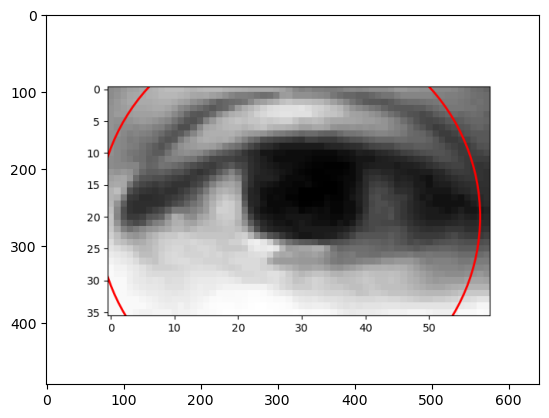

In [24]:
plt.imshow(disp_mask_blob)

In [25]:
#Functions

In [26]:
import numpy as np
from skimage.color import rgb2gray
import cv2
import os

from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib.image import imread
from matplotlib.patches import Circle
%matplotlib inline

from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve
from skimage.transform import resize
from skimage.morphology import *
from skimage.feature import blob_doh
from skimage.transform import hough_circle
from skimage.feature import canny
#functions used in edge canny from scratch

def gaussian_smoothing(img):
    smoothed_img = gaussian_filter(img, sigma=5)
    return smoothed_img

def gradient(img):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -1, -2]])
    sobel_x_img = convolve(img, sobel_x, mode='constant')
    sobel_y_img = convolve(img, sobel_y, mode='constant')
    g_magnitude = np.sqrt(sobel_x_img ** 2 + sobel_y_img ** 2)
    g_dir = np.arctan2(sobel_x_img, sobel_y_img)
    return g_magnitude, g_dir

def non_maximum_suppression(g_magnitude, g_dir):
    g_dir[g_dir < 0] += np.pi
    g_dir_hat = np.floor_divide(g_dir, np.pi / 4)
    g_max = np.zeros_like(g_magnitude)
    for x in range(1, g_magnitude.shape[0] - 1):
        for y in range(1, g_magnitude.shape[1] - 1):
            magnitude = g_magnitude[x, y]
            dir_hat = g_dir_hat[x, y]
            if dir_hat == 0:  # east/west
                if np.greater_equal(magnitude, g_magnitude[x, y-1]) and np.greater_equal(magnitude, g_magnitude[x, y+1]):
                    g_max[x, y] = magnitude
            elif dir_hat == 1: #northeast/southwest
                if np.greater_equal(magnitude, g_magnitude[x+1, y-1]) and np.greater_equal(magnitude, g_magnitude[x-1, y+1]):
                    g_max[x, y] = magnitude
            elif dir_hat == 2: #nort/south
                if np.greater_equal(magnitude, g_magnitude[x+1, y]) and np.greater_equal(magnitude, g_magnitude[x-1, y]):
                    g_max[x, y] = magnitude
            elif dir_hat == 3: #nortwest/southeast
                if np.greater_equal(magnitude, g_magnitude[x+1, y+1]) and np.greater_equal(magnitude, g_magnitude[x-1, y-1]):
                    g_max[x, y] = magnitude
    return g_max

def double_thresholding(g_max, thresh_lo, thresh_hi):
    thresh_img = np.zeros_like(g_max)
    for x in range(g_max.shape[0]):
      for y in range(g_max.shape[1]):
          mag = g_max[x, y]   
          if mag > thresh_hi:
              thresh_img[x, y] = 255 #strong
          elif mag > thresh_lo:
              thresh_img[x, y] = 128 #weak
    return thresh_img

def connectivity(thresh_img):
    edge_img = np.zeros_like(thresh_img)
    for x in range(thresh_img.shape[0]):
      for y in range(thresh_img.shape[1]):
        edge = thresh_img[x,y]
        if edge == 255:
          edge_img[x,y] = edge
        if edge == 128:
          if thresh_img[x-1,y-1]==255 or thresh_img[x-1,y]==255 or thresh_img[x,y-1]==255 or thresh_img[x+1,y]==255 or thresh_img[x+1,y+1]==255:
            edge_img[x,y] = edge
    return edge_img
# edge canny from scratch

def canny_edge_detector(img, thresh_lo=0.01, thresh_hi=0.04):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    
    
    # Smooth the image first. 
    smoothed             = gaussian_smoothing(img)
    
    # Find gradient magnitude and direction
    g_magnitude, g_dir   = gradient(smoothed)
    
    # Non-maximum suppression
    g_max                = non_maximum_suppression(g_magnitude, g_dir)
    
    # Double thresholding
    thresh_img           = double_thresholding(g_max, thresh_lo, thresh_hi)
    
    # Final edge connectivity
    edge_img             = connectivity(thresh_img)
    
    # Return the result
    return edge_img
# detect circles fromm scratch

def detectCircles(img,threshold,region,radius): 
    (M,N) = img.shape
    [R_max,R_min] = radius
    R = R_max - R_min
    #Initializing accumulator array.
    #Accumulator array is a 3 dimensional array with the dimensions representing
    #the radius, X coordinate and Y coordinate resectively.
    #Also appending a padding of 2 times R_max to overcome the problems of overflow
    A = np.zeros((R_max,M+2*R_max,N+2*R_max))
    B = np.zeros((R_max,M+2*R_max,N+2*R_max))

    #Precomputing all angles to increase the speed of the algorithm
    theta = np.arange(0,360)*np.pi/180
    edges = np.argwhere(img[:,:])                                               #Extracting all edge coordinates
    for val in range(R):
        r = R_min+val
        #Creating a Circle Blueprint
        bprint = np.zeros((2*(r+1),2*(r+1)))
        (m,n) = (r+1,r+1)                                                       #Finding out the center of the blueprint
        for angle in theta:
            x = int(np.round(r*np.cos(angle)))
            y = int(np.round(r*np.sin(angle)))
            bprint[m+x,n+y] = 1
        constant = np.argwhere(bprint).shape[0]
        for x,y in edges:                                                       #For each edge coordinates
            #Centering the blueprint circle over the edges
            #and updating the accumulator array
            X = [x-m+R_max,x+m+R_max]                                           #Computing the extreme X values
            Y= [y-n+R_max,y+n+R_max]                                            #Computing the extreme Y values
            A[r,X[0]:X[1],Y[0]:Y[1]] += bprint
        A[r][A[r]<threshold*constant/r] = 0

    for r,x,y in np.argwhere(A):
        temp = A[r-region:r+region,x-region:x+region,y-region:y+region]
        try:
            p,a,b = np.unravel_index(np.argmax(temp),temp.shape)
        except:
            continue
        B[r+(p-region),x+(a-region),y+(b-region)] = 1

    return B[:,R_max:-R_max,R_max:-R_max]


def displayCircles(image, coor):
    fig = plt.figure()
    plt.imshow(image)
    circleCoordinates = np.argwhere(coor)                                          #Extracting the circle information
    circle = []
    for r,x,y in circleCoordinates:
        circle.append(plt.Circle((y,x),r,color=(1,0,0),fill=False))
        fig.add_subplot(111).add_artist(circle[-1])
    plt.show()

def mask_image(gray, threshold):
    mask = gray > threshold
    return mask

def dilated_image(image, rep):
  dilated = dilation(image)
  for i in range(rep-1):
    dilated=dilation(dilated)
  return dilated

def NewdisplayCircles(image, coor, filename):
    h = image.shape[0]
    w = image.shape[1]
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Read in an image and display it on the axis
    ax.imshow(image)
    # Create a circle patch with the desired coordinates and radius
    circleCoordinates = np.argwhere(coor)
    circleCoordinates = np.mean(circleCoordinates, axis=0)
    if len(circleCoordinates)==0:
        circleCoordinates=[[1,h/2,w/2]]
    r,y,x = circleCoordinates
    circle = Circle((x,y), r, color='red', fill=False)
    # Add the circle patch to the axis
    ax.add_patch(circle)
    # Save the figure
    plt.savefig(filename)
    # close the figure
    plt.close(fig)
    # read the saved file and return the image
    return plt.imread(filename)

def output_coor_circles(image, coor):
    circleCoordinates = np.argwhere(coor)
    
    if len(circleCoordinates) == 0:
        # No circles detected, return a default value or handle it as needed
        return [0, 0, 0]  # Default values, modify as per your requirements
    else:
        circleCoordinates = np.mean(circleCoordinates, axis=0)
        return circleCoordinates

def displayBlob(image, blob, filename):
    h = image.shape[0]
    w = image.shape[1]
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Read in an image and display it on the axis
    ax.imshow(image)
    if len(blob)==0:
        blob=[[h/2,w/2,30]]
    blob = np.mean(blob, axis=0)
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)
    # Save the figure
    plt.savefig(filename)
    # close the figure
    plt.close(fig)
    # read the saved file and return the image
    return plt.imread(filename)

def output_coor_blob(image, blob):
    h = image.shape[0]
    w = image.shape[1]
    if len(blob)==0:
        blob=[[h/2,w/2,30]]
    blob = np.mean(blob, axis=0)
    y, x, r = blob
    return blob

C:\Users\Tanusha\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Tanusha\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


coords circle [0, 0]


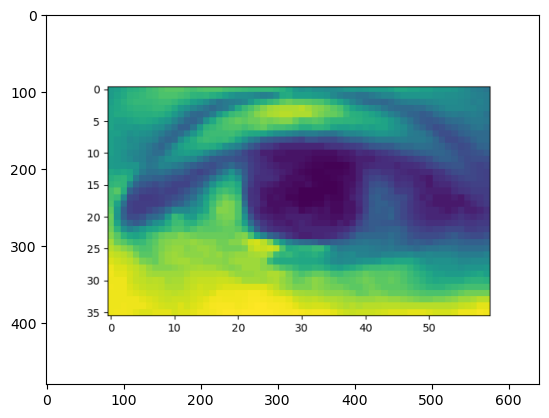

In [27]:
import numpy as np
from skimage.transform import hough_circle
from skimage.feature import canny
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

def draw_red_circle(image, center, radius):
    # Draw a red circular line on the image
    rr, cc = circle_perimeter(center[0], center[1], radius)
    image[rr, cc] = [1, 0, 0]  # Set the color to red
    
img = all_norm_df.iloc[0]['img']
gray = img  # Assuming 'img' is already a grayscale image
mask = mask_image(gray, 0.3)
dilated_mask = dilated_image(mask, 5)
dilated_mask_edge = canny(dilated_mask, sigma=3, low_threshold=0.2, high_threshold=0.4).astype(np.uint8)
coor_edge_dilated_mask = hough_circle(dilated_mask_edge, np.arange(5, 20))
disp_edge_dilated_mask = NewdisplayCircles(img, coor_edge_dilated_mask, "unity_eye_circle_estimation.png")
coor_circles = output_coor_circles(img, coor_edge_dilated_mask)
plt.imshow(disp_edge_dilated_mask)
print("coords circle", coor_circles[1:3])

In [28]:
all_norm_df

,img,vec1,vec2,group,day,vec1_x,vec1_y,vec1_z,vec2_x,vec2_y,vec2_z
0,"[[140, 144, 152, 160, 162, 167, 175, 179, 185,...","[-0.11597052575726613, 0.08862135352505127, -0...","[-0.1524740021745972, 0.11913672457310288, 0.0...",p00,day01,-0.115971,0.088621,-0.989291,-0.152474,0.119137,0.009111
1,"[[111, 117, 121, 131, 140, 140, 149, 153, 164,...","[-0.09372293933748573, 0.21454055450208137, -0...","[-0.17630004585004622, 0.026164775859324363, 0...",p00,day01,-0.093723,0.214541,-0.972208,-0.176300,0.026165,0.002313
2,"[[113, 116, 113, 121, 121, 136, 146, 150, 161,...","[-0.14710347860005538, 0.15676618879574278, -0...","[-0.18694673426994865, 0.05189600249785826, 0....",p00,day01,-0.147103,0.156766,-0.976619,-0.186947,0.051896,0.004866
3,"[[110, 110, 114, 118, 125, 131, 135, 146, 152,...","[0.05278899076799957, 0.05315222635792322, -0....","[-0.333516185565644, -0.09152606636817659, -0....",p00,day01,0.052789,0.053152,-0.997190,-0.333516,-0.091526,-0.015417
4,"[[108, 108, 108, 108, 121, 121, 125, 130, 138,...","[0.024747545916550293, 0.25614524540602923, -0...","[-0.23913339770532807, -0.05974066260464617, -...",p00,day01,0.024748,0.256145,-0.966321,-0.239133,-0.059741,-0.007179
...,...,...,...,...,...,...,...,...,...,...,...
213651,"[[213, 213, 209, 198, 182, 175, 175, 171, 160,...","[-0.10994429437485276, 0.010012749247265524, -...","[-0.47128371993981666, -0.021140822777776982, ...",p14,day07,-0.109944,0.010013,-0.993887,-0.471284,-0.021141,-0.005076
213652,"[[214, 199, 186, 173, 164, 164, 159, 144, 144,...","[-0.2016127541584455, 0.24403716734805214, -0....","[-0.5434424075212534, -0.04184656335255156, -0...",p14,day07,-0.201613,0.244037,-0.948577,-0.543442,-0.041847,-0.011661
213653,"[[220, 210, 202, 199, 202, 192, 165, 156, 165,...","[-0.3238863953671707, 0.22317794393044882, -0....","[-0.5515702421601711, -0.05832092237795787, -0...",p14,day07,-0.323886,0.223178,-0.919396,-0.551570,-0.058321,-0.016510
213654,"[[190, 187, 193, 193, 193, 193, 193, 187, 179,...","[-0.32629125001846637, -0.023389726413129384, ...","[-0.5167766946719523, -0.05882292474204975, -0...",p14,day07,-0.326291,-0.023390,-0.944980,-0.516777,-0.058823,-0.015552


In [29]:
!pip install pynput

In [ ]:
!pip install --upgrade scikit-learn
!conda update conda
!conda install -c conda-forge openblas
!pip show threadpoolctl
!pip install --upgrade threadpoolctl

In [ ]:
import numpy as np
from hmmlearn import hmm
import cv2
from pynput.mouse import Controller

mouse = Controller()
stop_camera = False
fixation_start_time = None
previous_pupil_position = None

def move_cursor(dx, dy):
    # Move the mouse cursor by the specified change in x and y coordinates.
    screen_width, screen_height = 1920, 1080  # Adjust based on your screen size and resolution
    current_x, current_y = mouse.position
    new_x = int(current_x + dx)
    new_y = int(current_y + dy)
    new_x = max(0, min(new_x, screen_width - 1))
    new_y = max(0, min(new_y, screen_height - 1))
    mouse.position = (new_x, new_y)

def simple_pupil_detection(frame):
    # Simple example of thresholding for pupil detection
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray_frame, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Get the centroid of the largest contour as the pupil position
        largest_contour = max(contours, key=cv2.contourArea)
        moments = cv2.moments(largest_contour)
        if moments["m00"] != 0:
            x = int(moments["m10"] / moments["m00"])
            y = int(moments["m01"] / moments["m00"])
            return x, y

    return None

def simulate_eye_click():
    mouse.click()

def capture_and_process():
    global stop_camera, fixation_start_time, previous_pupil_position
    stop_camera = False
    cap = cv2.VideoCapture(0)

    # Initialize HMM parameters (these need to be tuned based on your application)
    num_states = 2  # Number of states (e.g., fixating, not fixating)
    num_features = 2  # Number of features (x and y coordinates)
    model = hmm.GaussianHMM(n_components=num_states, covariance_type="full")

    # Generate synthetic training data (for demonstration purposes)
    np.random.seed(42)
    training_data = np.random.rand(100, num_features)

    # Fit the HMM model with training data
    model.fit(training_data)

    while True:
        ret, frame = cap.read()

        if not ret or frame is None:
            print("Error: Failed to capture a frame.")
            break

        # Simple pupil detection
        pupil_position = simple_pupil_detection(frame)

        # Observations for the HMM
        observation = np.array([[pupil_position[0], pupil_position[1]]]) if pupil_position else None

        # Make predictions only if the model is fitted
        if hasattr(model, "means_"):
            # Predict the state
            state = model.predict(observation.reshape(1, -1))[0]

            # Move the cursor based on the HMM state
            if state == 0:
                # State 0: Fixation
                if fixation_start_time is None:
                    fixation_start_time = cv2.getTickCount()
                fixation_duration = (cv2.getTickCount() - fixation_start_time) / cv2.getTickFrequency()
                if fixation_duration >= 2.0:
                    simulate_eye_click()
                    fixation_start_time = None
            else:
                # State 1: Not Fixation
                fixation_start_time = None

            # Move the cursor based on the change in pupil position
            if previous_pupil_position is not None and pupil_position is not None:
                cursor_dx = 10 * (pupil_position[0] - previous_pupil_position[0])
                cursor_dy = 10 * (pupil_position[1] - previous_pupil_position[1])
                move_cursor(cursor_dx, cursor_dy)

            previous_pupil_position = pupil_position

        cv2.imshow('Eye Ball Tracking', frame)

        if cv2.waitKey(1) & 0xFF == ord('q') or stop_camera:
            break

        cv2.waitKey(1)

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    capture_and_process()

In [ ]:
#clicking event

import cv2
import numpy as np
from skimage.feature import blob_doh
from skimage.morphology import dilation
from pynput.mouse import Controller

mouse = Controller()
stop_camera = False
fixation_start_time = None
previous_pupil_position = None

def move_cursor(dx, dy):
    # Move the mouse cursor by the specified change in x and y coordinates.
    screen_width, screen_height = 1920, 1080  # Adjust based on your screen size and resolution
    current_x, current_y = mouse.position
    new_x = int(current_x + dx)
    new_y = int(current_y + dy)
    new_x = max(0, min(new_x, screen_width - 1))
    new_y = max(0, min(new_y, screen_height - 1))
    mouse.position = (new_x, new_y)

def mask_image(gray, threshold):
    mask = gray > threshold
    return mask

def dilated_image(image, rep):
    dilated = dilation(image)
    for i in range(rep-1):
        dilated = dilation(dilated)
    return dilated

def get_pupil_position(blob_coordinates):
    if len(blob_coordinates) > 0:
        average_blob = np.mean(blob_coordinates, axis=0)
        return average_blob[1], average_blob[0]
    else:
        return None

def simulate_eye_click():
    mouse.click()

def capture_and_process():
    global stop_camera, fixation_start_time, previous_pupil_position
    stop_camera = False
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()

        if not ret or frame is None:
            print("Error: Failed to capture a frame.")
            break

        downscale_factor = 0.5
        downscale_frame = cv2.resize(frame, None, fx=downscale_factor, fy=downscale_factor)

        gray_frame = cv2.cvtColor(downscale_frame, cv2.COLOR_BGR2GRAY)

        threshold = np.mean(gray_frame) / 255.0
        mask = mask_image(gray_frame, threshold)
        dilated_mask = dilated_image(mask, 5)
        dilated_mask_edge = cv2.Canny(dilated_mask.astype(np.uint8) * 255, 50, 150)

        dilated_mask_edge = cv2.resize(dilated_mask_edge, (frame.shape[1], frame.shape[0]))

        coor_edge_dilated_mask = blob_doh(dilated_mask_edge, max_sigma=30, min_sigma=5, threshold=.005)

        pupil_position = get_pupil_position(coor_edge_dilated_mask)

        if pupil_position is not None:
            # Start measuring fixation duration
            if fixation_start_time is None:
                fixation_start_time = cv2.getTickCount()

            # Check if fixation has lasted long enough (in seconds)
            fixation_duration = (cv2.getTickCount() - fixation_start_time) / cv2.getTickFrequency()
            if fixation_duration >= 2.0:
                # Simulate a mouse click if fixation is longer than 2 seconds
                simulate_eye_click()

                # Reset fixation start time
                fixation_start_time = None
        else:
            # Reset fixation start time if eyes are not detected
            fixation_start_time = None

        # Move the cursor based on the change in pupil position
        if previous_pupil_position is not None and pupil_position is not None:
            cursor_dx = 10 * (pupil_position[0] - previous_pupil_position[0])
            cursor_dy = 10 * (pupil_position[1] - previous_pupil_position[1])
            move_cursor(cursor_dx, cursor_dy)

        previous_pupil_position = pupil_position

        cv2.imshow('Eye Ball Tracking', frame)

        if cv2.waitKey(1) & 0xFF == ord('q') or stop_camera:
            break

        cv2.waitKey(1)

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    capture_and_process()

In [ ]:
import cv2
import numpy as np
from skimage.transform import resize
from skimage.feature import blob_doh
from skimage.morphology import dilation
from pynput.mouse import Controller
import os
import pandas as pd
from glob import glob
from skimage.io import imread
import matplotlib.pyplot as plt

mouse = Controller()
stop_camera = False  # Flag to signal when to stop the camera

def move_cursor(dx, dy):
    # Move the mouse cursor by the specified change in x and y coordinates.
    screen_width, screen_height = 1920, 1080  # Adjust based on your screen size and resolution
    current_x, current_y = mouse.position
    new_x = int(current_x + dx)
    new_y = int(current_y + dy)
    new_x = max(0, min(new_x, screen_width - 1))
    new_y = max(0, min(new_y, screen_height - 1))
    mouse.position = (new_x, new_y)

def read_annot(in_path):
    r_dir = os.path.splitext(os.path.basename(in_path))[0]
    c_df = pd.read_table(in_path, header=None, sep=' ')
    if c_df.shape[1] > 1:
        c_df.columns = ['path' if i == 0 else 'x{}'.format(i-1) for i in range(c_df.shape[1])]
        c_df['path'] = c_df['path'].map(lambda x: os.path.join(img_dir, r_dir, x))
    else:
        c_df.columns = ['path']
        c_df['path'] = c_df['path'].map(lambda x: os.path.join(img_dir, r_dir, x))
    if 'path' not in c_df.columns:
        print(f"Error: 'path' column not found in DataFrame for file {in_path}")
        print(f"Columns present: {c_df.columns}")
    c_df['group'] = r_dir
    c_df['exists'] = c_df['path'].map(os.path.exists)
    return c_df

all_annot_df = pd.concat([read_annot(c_path) for c_path in glob(os.path.join(annot_dir, '*'))], ignore_index=True)
print(all_annot_df.shape[0], 'annotations')
print('Missing %2.2f%%\n' % (100-100*all_annot_df['exists'].mean()))
all_annot_df = all_annot_df[all_annot_df['exists']].drop('exists', 1)
all_annot_df.sample(3)

# Print DataFrame to check if 'path' column is present
print("Annotations:", all_annot_df.head())

def get_eyeball(in_row, eye_height=30):
    try:
        c_img = imread(in_row['path'])
        min_x = int(in_row['x0'])
        max_x = int(in_row['x1'])
        mean_x = (min_x+max_x)/2
        wid_x = (max_x-min_x)
        zoom_factor = 55.0/wid_x
        mean_y = (in_row['y0']+in_row['y1'])/2
        eye_height = 1/zoom_factor*35
        pup_v = 2*zoom_factor*(in_row['x6']-mean_x)/wid_x, 2*zoom_factor*(in_row['y6']-mean_y)/eye_height
        min_y = int(mean_y-eye_height//2)
        max_y = int(mean_y+eye_height//2)
        out_img = c_img[min_y:max_y, min_x:max_x]
        rs_img = zoom(out_img, (zoom_factor, zoom_factor, 1))
        return rs_img, pup_v

    except KeyError:
        print(f"Error: 'path' column not found in DataFrame.")
        return None, None

def displayBlob(image, blob, filename):
    h, w = image.shape[:2]  # Get height and width
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')  # Use a grayscale colormap for display
    if len(blob) == 0:
        blob = [[h / 2, w / 2, 30]]
    blob = np.mean(blob, axis=0)
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)
    plt.savefig(filename)
    plt.close(fig)
    return plt.imread(filename)

# Assuming img is your grayscale image
print("\nLength of images:", len(img))
gray = img  # No need for rgb2gray if the image is already grayscale
print("Length of gray scaled images:", len(gray))
mask = gray > 0.2
mask_blob = blob_doh(mask, max_sigma=30, min_sigma=5, threshold=.005)
disp_mask_blob = displayBlob(gray, mask_blob, "/kaggle/working/gray_blob_{}.png".format(i))

def displayCircles(image, coor):
    fig = plt.figure()
    plt.imshow(image)
    circleCoordinates = np.argwhere(coor)
    circle = []
    for r, x, y in circleCoordinates:
        circle.append(plt.Circle((y, x), r, color=(1, 0, 0), fill=False))
        fig.add_subplot(111).add_artist(circle[-1])
    plt.show()

def mask_image(gray, threshold):
    mask = gray > threshold
    return mask

def dilated_image(image, rep):
    dilated = dilation(image)
    for i in range(rep-1):
        dilated = dilation(dilated)
    return dilated

def NewdisplayCircles(image, coor, filename):
    h, w = image.shape[:2]
    fig, ax = plt.subplots()
    ax.imshow(image)
    circleCoordinates = np.argwhere(coor)
    if len(circleCoordinates) == 0:
        circleCoordinates = [[1, h/2, w/2]]
    if len(circleCoordinates[0]) == 3:
        r, y, x = circleCoordinates[0]
        circle = Circle((x, y), r, color='red', fill=False)
        ax.add_patch(circle)
        plt.savefig(filename)
        plt.close(fig)
        return plt.imread(filename)
    else:
        print("Error: Circle information does not have the expected length.")
        return None

def output_coor_circles(image, coor):
    circleCoordinates = np.argwhere(coor)
    circleCoordinates = np.mean(circleCoordinates, axis=0)
    return circleCoordinates

def displayBlob(image, blob, filename):
    h, w = image.shape[:2]
    fig, ax = plt.subplots()
    ax.imshow(image)
    if len(blob) == 0:
        blob = [[h/2, w/2, 30]]
    blob = np.mean(blob, axis=0)
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)
    plt.savefig(filename)
    plt.close(fig)
    return plt.imread(filename)

def output_coor_blob(image, blob):
    h, w = image.shape[:2]
    if len(blob) == 0:
        blob = [[h / 2, w / 2, 30]]  # Default values if no circles are detected
    blob = np.mean(blob, axis=0)
    y, x, r = blob
    return blob

def get_pupil_position(blob_coordinates):
    if len(blob_coordinates) > 0:
        average_blob = np.mean(blob_coordinates, axis=0)
        return average_blob[1], average_blob[0]
    else:
        return None

def translate_eye_movement_to_cursor(pupil_position):
    screen_width, screen_height = 1920, 1080
    cursor_speed = 5
    cursor_dx = cursor_speed * pupil_position[0]
    cursor_dy = cursor_speed * pupil_position[1]
    current_x, current_y = mouse.position
    new_x = int(current_x + cursor_dx)
    new_y = int(current_y + cursor_dy)
    new_x = max(0, min(new_x, screen_width - 1))
    new_y = max(0, min(new_y, screen_height - 1))
    print("Tracked Cursor Coordinates:", (new_x, new_y))
    mouse.position = (new_x, new_y)

def draw_red_line(image):
    cv2.line(image, (0, 0), (image.shape[1], image.shape[0]), (255, 0, 0), 2)

def capture_and_process():
    global stop_camera
    stop_camera = False
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()

        # Check if the frame is valid
        if not ret or frame is None:
            print("Error: Failed to capture a frame.")
            break

        # Downscale the frame before processing
        downscale_factor = 0.5
        downscale_frame = cv2.resize(frame, None, fx=downscale_factor, fy=downscale_factor)

        gray_frame = cv2.cvtColor(downscale_frame, cv2.COLOR_BGR2GRAY)

        # Dynamic threshold based on the mean intensity of the frame
        threshold = np.mean(gray_frame) / 255.0
        mask = mask_image(gray_frame, threshold)
        dilated_mask = dilated_image(mask, 5)
        dilated_mask_edge = cv2.Canny(dilated_mask.astype(np.uint8) * 255, 50, 150)

        # Upscale the detected edges to the original size
        dilated_mask_edge = cv2.resize(dilated_mask_edge, (frame.shape[1], frame.shape[0]))

        coor_edge_dilated_mask = blob_doh(dilated_mask_edge, max_sigma=30, min_sigma=5, threshold=.005)

        disp_edge_dilated_mask = NewdisplayCircles(frame, coor_edge_dilated_mask, "unity_eye_circle_estimation.png")

        if disp_edge_dilated_mask is not None:
            cv2.imshow('Eye Ball Tracking', disp_edge_dilated_mask)

        pupil_position = get_pupil_position(coor_edge_dilated_mask)

        if pupil_position is not None:
            translate_eye_movement_to_cursor(pupil_position, frame.shape)
            stop_camera = True

        if cv2.waitKey(1) & 0xFF == ord('q') or stop_camera:
            break

        cv2.waitKey(10)

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    capture_and_process()

In [ ]:
import cv2
import numpy as np
import pyautogui
# Initialize PyAutoGUI
pyautogui.FAILSAFE = False
# Initialize OpenCV
cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
# Define the screen size
screen_width, screen_height = pyautogui.size()
# Define the eye movement threshold
eye_threshold = 20
# Define the eye position
eye_position = None
# Loop through the video stream
while True:
    # Read the frame
    ret, frame = cap.read()
    
    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    # Loop through the faces
    for (x,y,w,h) in faces:
        # Draw a rectangle around the face
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        
        # Crop the face region
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        
        # Detect eyes in the face region
        eyes = eye_cascade.detectMultiScale(roi_gray)
        
        # Loop through the eyes
        for (ex,ey,ew,eh) in eyes:
            # Draw a rectangle around the eye
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
            
            # Calculate the eye position
            eye_x = ex + ew/2
            eye_y = ey + eh/2
            
            # Check if the eye position has changed
            if eye_position is not None:
                if abs(eye_x - eye_position[0]) > eye_threshold or abs(eye_y - eye_position[1]) > eye_threshold:
                    # Move the mouse
                    pyautogui.moveTo(screen_width * eye_x / w, screen_height * eye_y / h)
            
            # Update the eye position
            eye_position = (eye_x, eye_y)
    
    # Show the frame
    cv2.imshow('frame',frame)
    
    # Exit on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
# Release the video stream and close all windows
cap.release()
cv2.destroyAllWindows()

In [ ]:
!pip install pynput

In [ ]:
import cv2
import numpy as np
from skimage.feature import blob_doh
from skimage.morphology import dilation
from pynput.mouse import Controller, Button

mouse = Controller()
stop_camera = False
fixation_start_time = None
previous_pupil_position = None
pupil_positions = []

def move_cursor(x, y):
    mouse.position = (x, y)

def mask_image(gray, threshold):
    mask = gray > threshold
    return mask

def dilated_image(image, rep):
    dilated = dilation(image)
    for i in range(rep-1):
        dilated = dilation(dilated)
    return dilated

def get_pupil_position(blob_coordinates):
    if len(blob_coordinates) > 0:
        average_blob = np.mean(blob_coordinates, axis=0)
        return int(average_blob[1]), int(average_blob[0])
    else:
        return None

def simulate_eye_click():
    mouse.click(button=Button.left)

def detect_eye_blink(pupil_positions):
    if len(pupil_positions) >= 2:
        previous_size = np.linalg.norm(np.array(pupil_positions[-2]) - np.array(pupil_positions[-1]))
        current_size = np.linalg.norm(np.array(pupil_positions[-1]))

        blink_threshold = 0.8  # Adjust as needed
        if current_size < blink_threshold * previous_size:
            return True
    return False

def capture_and_process():
    global stop_camera, fixation_start_time, previous_pupil_position, pupil_positions
    stop_camera = False
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()

        if not ret or frame is None:
            print("Error: Failed to capture a frame.")
            break

        downscale_factor = 0.5
        downscale_frame = cv2.resize(frame, None, fx=downscale_factor, fy=downscale_factor)

        gray_frame = cv2.cvtColor(downscale_frame, cv2.COLOR_BGR2GRAY)

        threshold = np.mean(gray_frame) / 255.0
        mask = mask_image(gray_frame, threshold)
        dilated_mask = dilated_image(mask, 5)
        dilated_mask_edge = cv2.Canny(dilated_mask.astype(np.uint8) * 255, 50, 150)

        dilated_mask_edge = cv2.resize(dilated_mask_edge, (frame.shape[1], frame.shape[0]))

        coor_edge_dilated_mask = blob_doh(dilated_mask_edge, max_sigma=30, min_sigma=5, threshold=.005)

        pupil_position = get_pupil_position(coor_edge_dilated_mask)

        if pupil_position is not None:
            pupil_positions.append(pupil_position)

            if detect_eye_blink(pupil_positions):
                simulate_eye_click()
                pupil_positions = []  # Reset pupil positions after blink detection

            # Start measuring fixation duration
            if fixation_start_time is None:
                fixation_start_time = cv2.getTickCount()

            # Check if fixation has lasted long enough (in seconds)
            fixation_duration = (cv2.getTickCount() - fixation_start_time) / cv2.getTickFrequency()
            if fixation_duration >= 2.0:
                # Simulate a mouse click if fixation is longer than 2 seconds
                simulate_eye_click()

                # Reset fixation start time
                fixation_start_time = None
        else:
            # Reset fixation start time and pupil positions if eyes are not detected
            fixation_start_time = None
            pupil_positions = []

        if previous_pupil_position is not None and pupil_position is not None:
            move_cursor(pupil_position[0], pupil_position[1])

        previous_pupil_position = pupil_position

        cv2.imshow('Eye Ball Tracking', frame)

        if cv2.waitKey(1) & 0xFF == ord('q') or stop_camera:
            break

        cv2.waitKey(1)

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    capture_and_process()